## N Brown Data Science Recruitment Exercise - Size Prediction

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE

from sklearn.model_selection import GridSearchCV

## 0) Loading and pre-preprocessing

In [2]:
# train 
train = pd.read_csv('uc_data_train.csv').drop('Unnamed: 0', axis=1)
print(train.shape)
train.head()

(80001, 14)


,customer_id,size_womenswear,total_number_of_orders,return_rate,first_order_channel,socioeconomic_status,size_corsetry_cup,size_corsetry_briefs,size_footware,days_since_first_order,brand,age_in_years,socioeconomic_desc,order_method
0,1,16,28,0.12,1,C,7,16,7,4964,Brand 1,47,Country Living,offline
1,2,20,118,0.61,2,H,3,20,6,5578,other,73,Aspiring Homemakers,online
2,3,8,125,0.04,2,F,3,12,4,4112,other,65,Suburban Stability,online
3,4,12,109,0.42,1,F,5,12,7,4261,Brand 1,69,Suburban Stability,offline
4,5,16,37,0.26,1,I,4,16,6,2432,other,62,Family Basics,offline


In [3]:
# test
test = pd.read_csv('uc_data_test.csv').drop('Unnamed: 0', axis=1)
print(test.shape)
test.head()

(19999, 13)


,customer_id,total_number_of_orders,return_rate,first_order_channel,socioeconomic_status,size_corsetry_cup,size_corsetry_briefs,size_footware,days_since_first_order,brand,age_in_years,socioeconomic_desc,order_method
0,7,17,0.26,2,M,4,20,6,1602,Brand 3,43,Modest Traditions,online
1,8,30,0.52,2,L,4,16,8,1809,other,47,Vintage Value,online
2,9,9,0.31,2,I,9,16,6,179,Brand 3,60,Family Basics,online
3,13,109,0.08,2,M,3,16,7,4455,other,65,Modest Traditions,online
4,24,135,0.10,2,F,3,24,6,8752,other,70,Suburban Stability,online


In [4]:
# info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80001 entries, 0 to 80000
Data columns (total 14 columns):
customer_id               80001 non-null int64
size_womenswear           80001 non-null int64
total_number_of_orders    80001 non-null int64
return_rate               80001 non-null float64
first_order_channel       80001 non-null int64
socioeconomic_status      80001 non-null object
size_corsetry_cup         80001 non-null int64
size_corsetry_briefs      80001 non-null int64
size_footware             80001 non-null int64
days_since_first_order    80001 non-null int64
brand                     80001 non-null object
age_in_years              80001 non-null int64
socioeconomic_desc        80001 non-null object
order_method              80001 non-null object
dtypes: float64(1), int64(9), object(4)
memory usage: 8.5+ MB


### **Checking for outliers**

In [5]:
numeric = list(train.select_dtypes(include=[np.number]).columns)
numeric

['customer_id',
 'size_womenswear',
 'total_number_of_orders',
 'return_rate',
 'first_order_channel',
 'size_corsetry_cup',
 'size_corsetry_briefs',
 'size_footware',
 'days_since_first_order',
 'age_in_years']

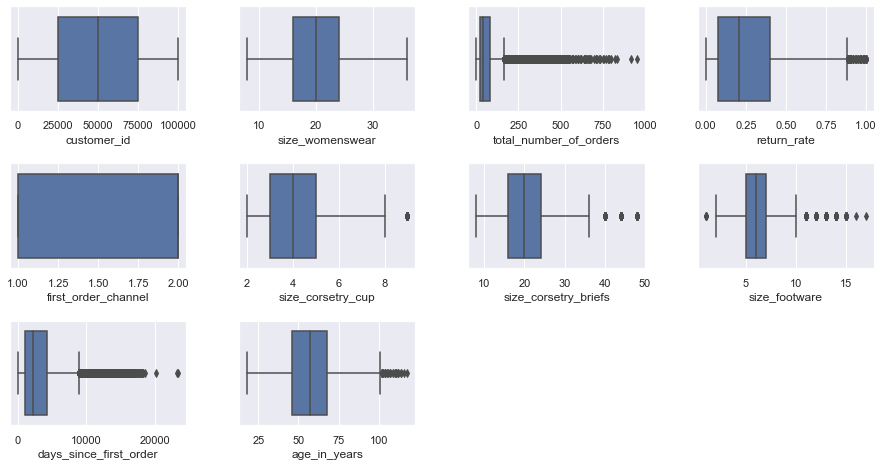

In [6]:
# boxplots
for i, feat in enumerate(numeric):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(feat, data=train)

plt.subplots_adjust(left=0, bottom=-1, right=2, top=1, wspace=0.3, hspace=0.5)
plt.show()

In [7]:
# percentage of centenarians
len(train[train['age_in_years'] >= 100]) / len(train) * 100

0.04499943750703116

"In 2018, there were an estimated 13,170 centenarians in the UK"
https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/ageing/bulletins/estimatesoftheveryoldincludingcentenarians/2002to2018

In [8]:
# percentage of UK centenarians in 2018
13170/66440000 * 100

0.01982239614689946

I will assume the data has no outliers.

### **Converting the categorical variables to numeric:**

In [9]:
categorical = list(train.select_dtypes('object').columns)
categorical

['socioeconomic_status', 'brand', 'socioeconomic_desc', 'order_method']

In [10]:
# print unique values
[print(i, sorted(train[i].unique()), "\n") for i in categorical]

# create lists with the categories sorted (LabelEncoder generates alphabetically)
for i in categorical:
    globals()['list_{}'.format(i)] = sorted(train[i].unique())
    

socioeconomic_status ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'U'] 

brand ['Brand 1', 'Brand 2', 'Brand 3', 'other'] 

socioeconomic_desc ['Aspiring Homemakers', 'City Prosperity', 'Country Living', 'Domestic Success', 'Family Basics', 'Modest Traditions', 'Municipal Challenge', 'Prestige Positions', 'Rental Hubs', 'Rural Reality', 'Senior Security', 'Suburban Stability', 'Transient Renters', 'Unclassified', 'Urban Cohesion', 'Vintage Value'] 

order_method ['offline', 'online'] 



In [11]:
# convert categorical variables to numeric
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

for i in categorical:
    train[i] = enc.fit_transform(train[i])    

## 1) Exploratory Data Analysis

### **1.1) Variables distributions**

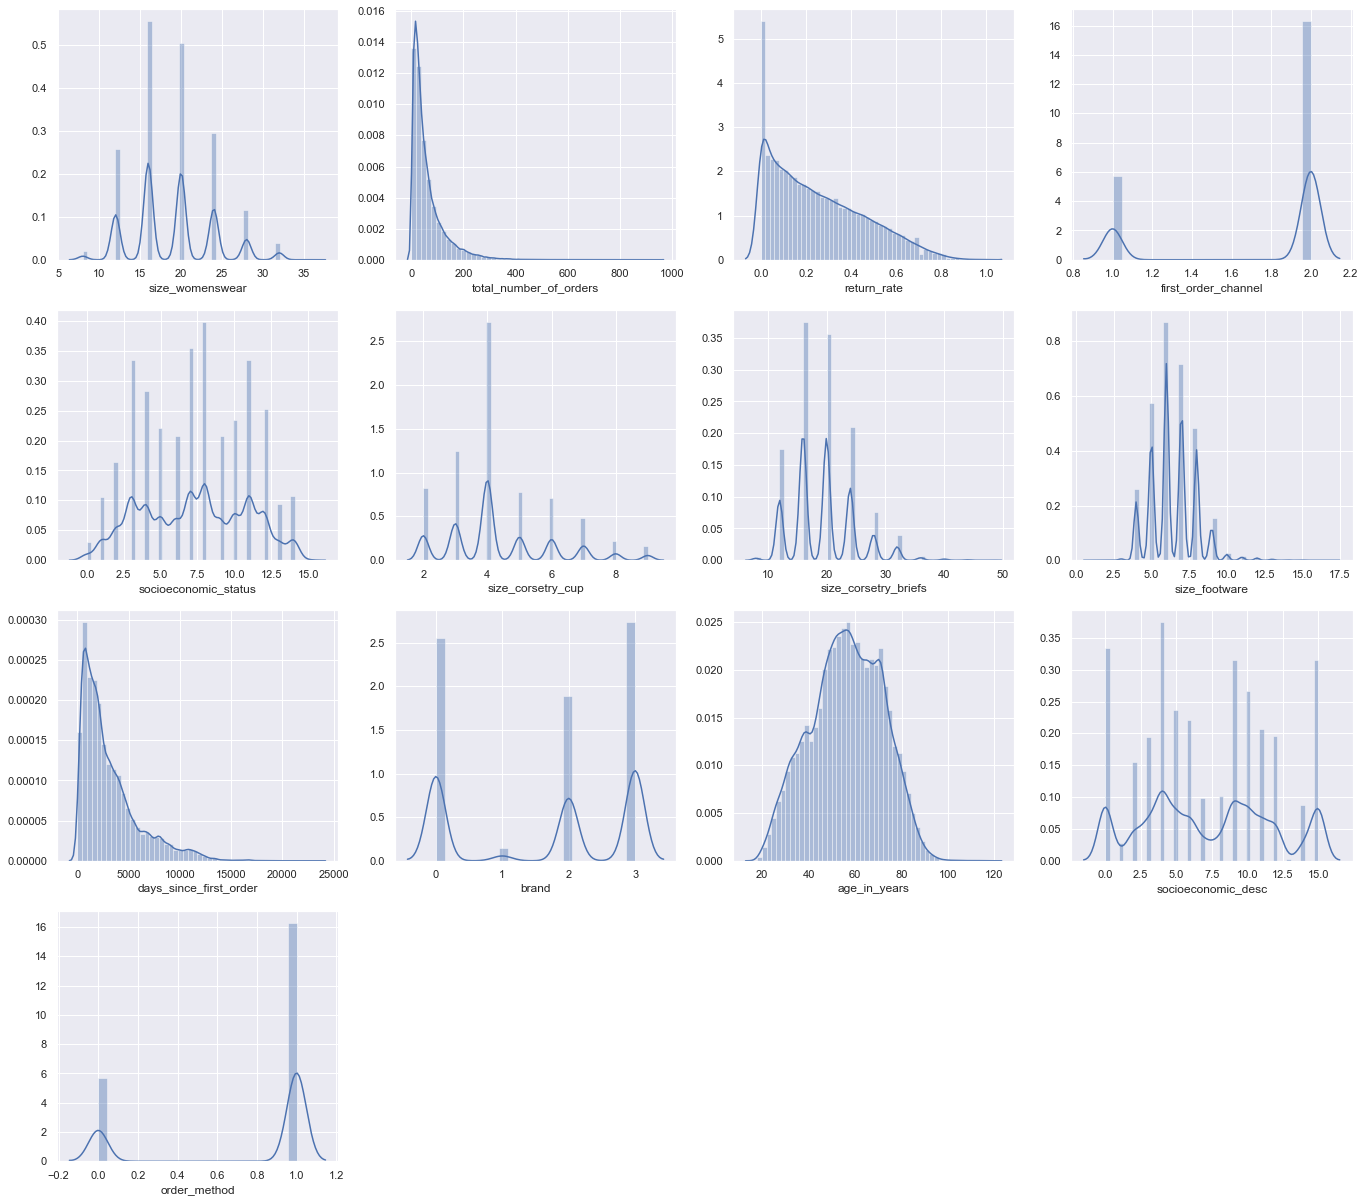

In [12]:
# all variable distributions glimpse
for i, feat in enumerate(train.columns[1:]):
    plt.subplot(4, 4, i + 1)
    sns.distplot(train[feat])

plt.subplots_adjust(left=0, bottom=-3, right=3, top=1, wspace=0.2, hspace=0.2)
plt.show()

### **1.2) Womenswear Size**

In [13]:
# unique sizes
print("Sizes: ", sorted(train['size_womenswear'].unique()))

Sizes:  [8, 12, 16, 20, 24, 28, 32, 36]


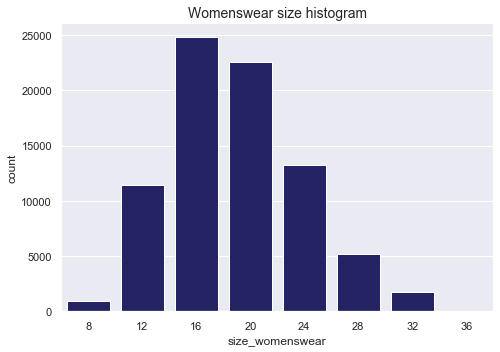

In [14]:
# histogram
sns.countplot(train['size_womenswear'], color='midnightblue')
plt.title('Womenswear size histogram', fontsize=14)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()

### **Relationship between size_womenswear and others**

In [15]:
train.columns

Index(['customer_id', 'size_womenswear', 'total_number_of_orders',
       'return_rate', 'first_order_channel', 'socioeconomic_status',
       'size_corsetry_cup', 'size_corsetry_briefs', 'size_footware',
       'days_since_first_order', 'brand', 'age_in_years', 'socioeconomic_desc',
       'order_method'],
      dtype='object')

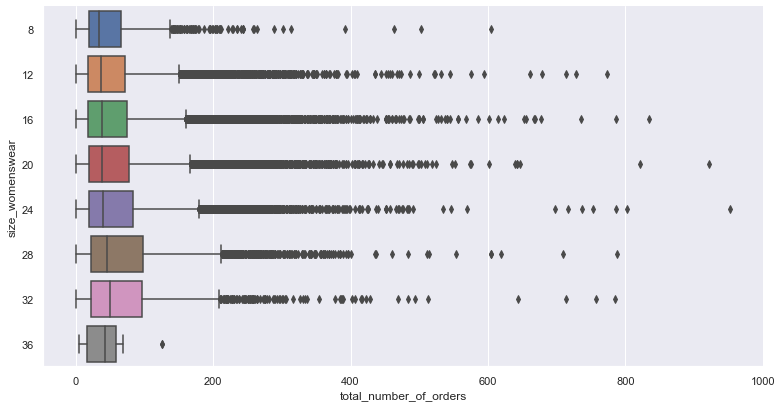

Correlation between total_number_of_orders and size: 0.057444103737236976


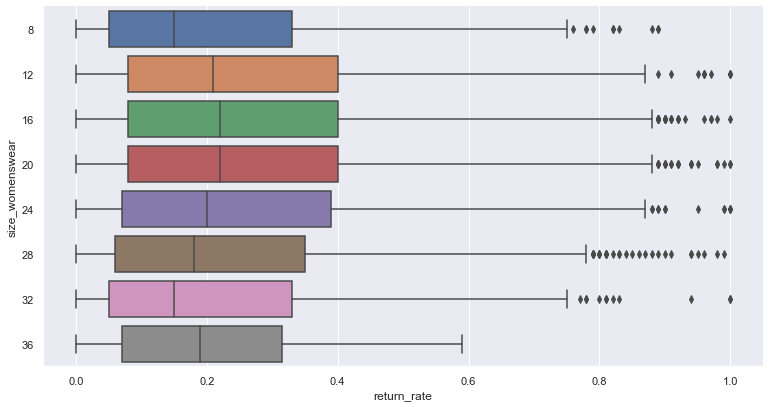

Correlation between return_rate and size: -0.03510939962153653


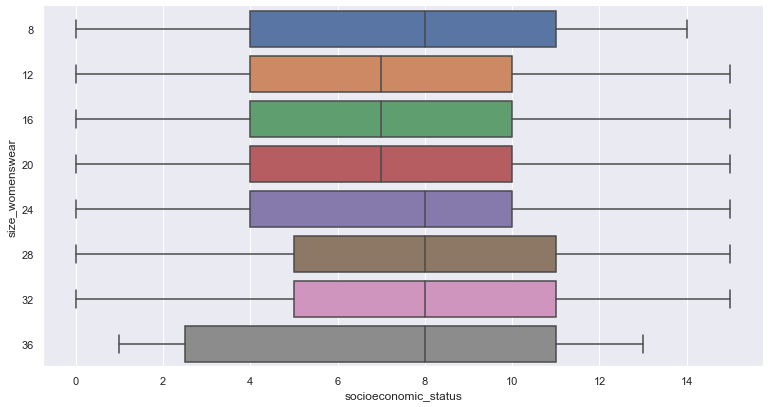

Correlation between socioeconomic_status and size: 0.030330081413044174


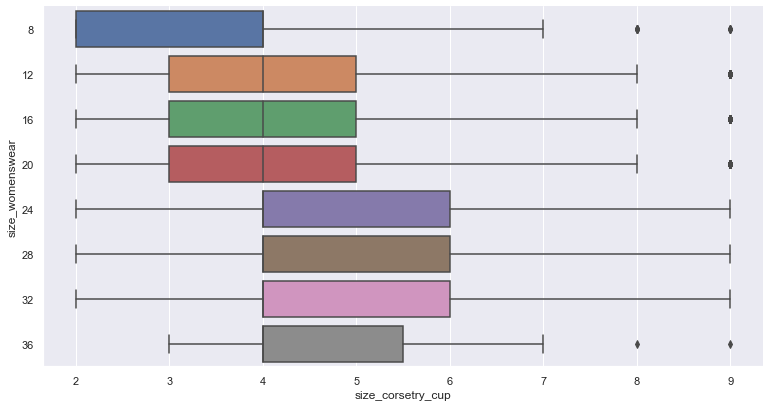

Correlation between size_corsetry_cup and size: 0.1381981947360931


In [16]:
# First 5. Excludind customer_id, size_womenswear and binary variables
for i in train.columns[2:][:5].drop('first_order_channel'):  
    sns.catplot(i, 'size_womenswear', data=train, kind='box', orient="h")
    plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0.3, hspace=0.5)
    plt.show()
    print("""Correlation between {} and size: {}""".format(i, train['size_womenswear'].corr(train[i])))


- Customers of **larger dress size** tend to **buy slightly more**.
- Customers with the **most common dress sizes**, namely 12, 16, 20 and 24, tend to be associated with **higher return rates**. 
- There seems to be a slight association between higher socioeconomic status and dress size, but not too significant.
- As expected, there is a **positive relationship** between dress size and both the **size of corsetry cup and briefs, specially strong with the latter. Both effects are statistically significant.** 

In [17]:
%%time
# Hypothesis test on Pearson correlation (corsetry cup)

# Let's see if the oberved correlation between size and corsetry cup (0.13) can be attributable to chance

# function for generating the correlation coefficient
def pearson_corr_coeff(data_1, data_2):
    return np.corrcoef(data_1, data_2)[0, 1]

# function for generating a permutation replicate
def permutation_sample(data1, data2):
    data = np.concatenate((data1, data2))
    permuted_data = np.random.permutation(data)
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
    return perm_sample_1, perm_sample_2

# Generating permutation replicates
def draw_perm_reps(data_1, data_2, func, size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
    return perm_replicates

# observed value 
print("Observed Correlation coefficient:", pearson_corr_coeff(train['size_womenswear'], train['size_corsetry_cup']))

###############################################

# Null hypothesis: "the two variables are completely uncorrelated" 

corr_coeff_observed = pearson_corr_coeff(train['size_womenswear'], train['size_corsetry_cup'])

# Drawing 10000 permutations
permutations = draw_perm_reps(train['size_womenswear'], train['size_corsetry_cup'], pearson_corr_coeff, 10000)

p_value = np.sum(permutations >= corr_coeff_observed) / len(permutations)
print("p-value:", p_value)


Observed Correlation coefficient: 0.1381981947360931
p-value: 0.0
Wall time: 1min 17s


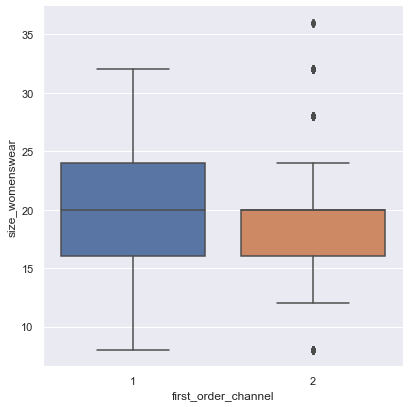

20.0

In [18]:
# first_order_channel
sns.catplot('first_order_channel', 'size_womenswear', data=train, kind='box')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.5)
plt.show()

np.median(train[train['first_order_channel'] == 2].size_womenswear)

In [19]:
train['first_order_channel'].value_counts()

2    59249
1    20752
Name: first_order_channel, dtype: int64

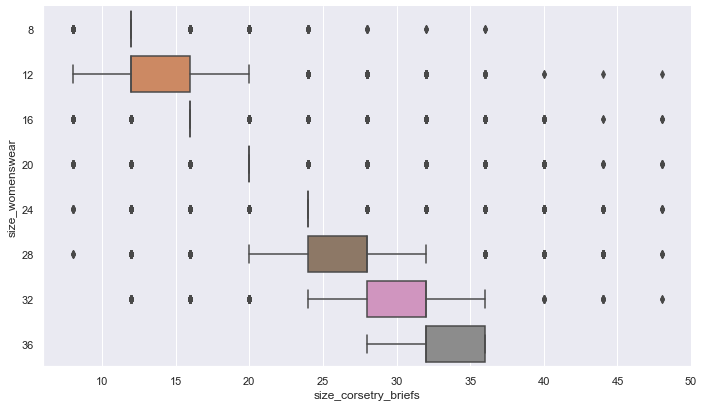

Correlation between size_corsetry_briefs and size: 0.7826653122721997


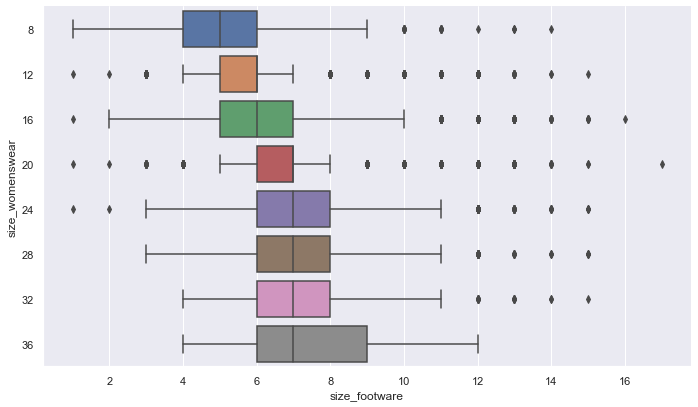

Correlation between size_footware and size: 0.2976746606912714


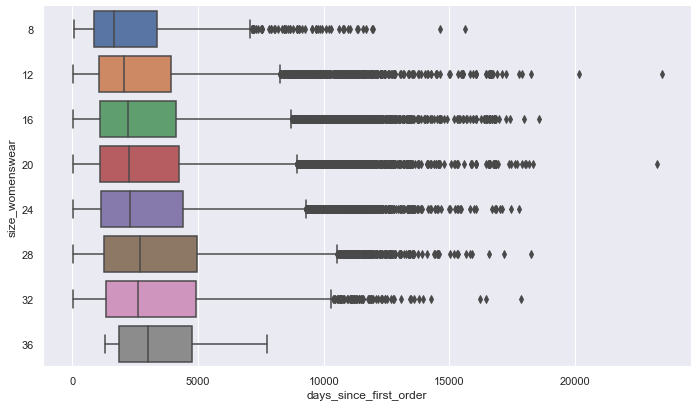

Correlation between days_since_first_order and size: 0.061438377909332806


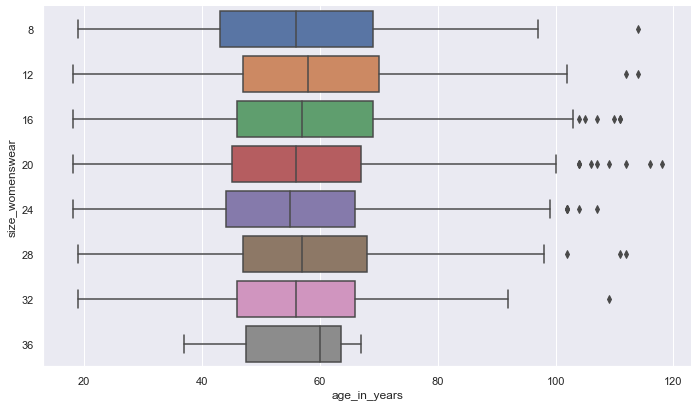

Correlation between age_in_years and size: -0.04861397228070826


In [20]:
# Next 5. Excludind customer_id, size_womenswear and binary variables
for i in train.columns[2:][5:10].drop('brand'):  
    sns.catplot(i, 'size_womenswear', data=train, kind='box', orient="h")
    plt.subplots_adjust(left=0, bottom=0, right=1.8, top=1, wspace=0.3, hspace=0.5)
    plt.show()
    print("""Correlation between {} and size: {}""".format(i, train['size_womenswear'].corr(train[i])))
    

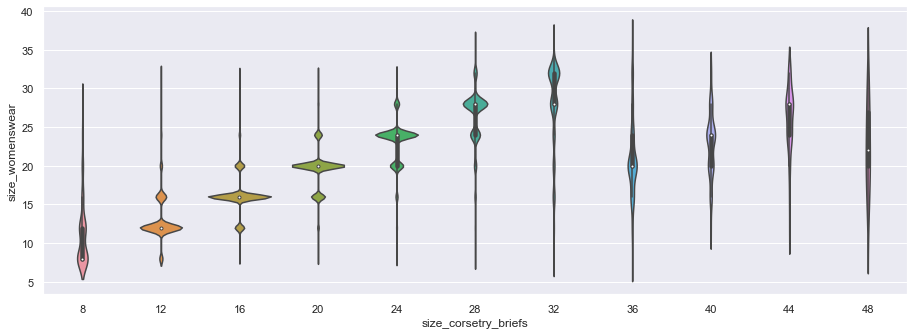

In [21]:
# size_corsetry_briefs vs size
sns.violinplot('size_corsetry_briefs', 'size_womenswear', data=train)

plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0.3, hspace=0.5)
plt.show()

In [22]:
# mean size by group age
print(train[(train['age_in_years'] >= 0) & (train['age_in_years'] <= 20)].size_womenswear.mean())
print(train[(train['age_in_years'] > 20) & (train['age_in_years'] <= 30)].size_womenswear.mean())
print(train[(train['age_in_years'] > 30) & (train['age_in_years'] <= 40)].size_womenswear.mean())
print(train[(train['age_in_years'] > 40) & (train['age_in_years'] <= 50)].size_womenswear.mean())
print(train[(train['age_in_years'] > 50) & (train['age_in_years'] <= 60)].size_womenswear.mean())
print(train[(train['age_in_years'] > 60) & (train['age_in_years'] <= 70)].size_womenswear.mean())
print(train[(train['age_in_years'] > 70) & (train['age_in_years'] <= 80)].size_womenswear.mean())
print(train[(train['age_in_years'] > 80) & (train['age_in_years'] <= 90)].size_womenswear.mean())
print(train[(train['age_in_years'] > 90) & (train['age_in_years'] <= 100)].size_womenswear.mean())
print(train[(train['age_in_years'] > 100) & (train['age_in_years'] <= 120)].size_womenswear.mean())

19.55
19.129161747343566
18.966175555094416
19.159448544770925
19.107680921922082
18.95064811511476
18.510963622616146
17.972482113373694
16.58471760797342
19.393939393939394


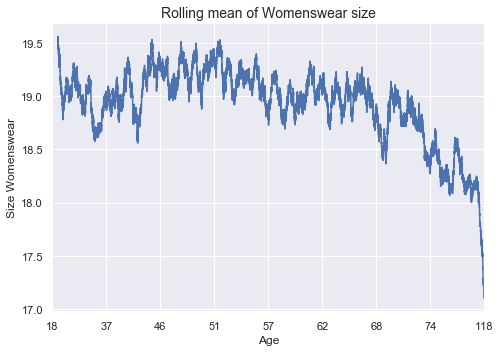

In [23]:
# rolling mean
train.sort_values('age_in_years').size_womenswear.reset_index(drop=True).rolling(1000).mean().plot()

# formatting
plt.title('Rolling mean of Womenswear size', fontsize=14)
plt.ylabel('Size Womenswear')
plt.xlabel('Age')
plt.xticks(np.arange(0, 90000, 10000),
           [train.sort_values('age_in_years').age_in_years.reset_index(drop=True)[i] for i in np.arange(0, 90000, 10000)])

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()

- **Footware size** is positively correlated with dress size.
- New customers tend not to alter too much tendencies on size.
- Age is not significantly correlated with size, but larger sizes (36) are not used by customers older than 67. Age groups between 18 and 30, 40 and 50, and 50 and 60 are the ones with larger mean sizes.

In [24]:
%%time
# Footware size correlation test

print("Observed Correlation coefficient:", pearson_corr_coeff(train['size_womenswear'], train['size_footware']))

###############################################

# Null hypothesis: "the two variables are completely uncorrelated" 

corr_coeff_observed = pearson_corr_coeff(train['size_womenswear'], train['size_footware'])

# Drawing 10000 permutations
permutations = draw_perm_reps(train['size_womenswear'], train['size_footware'], pearson_corr_coeff, 10000)

p_value = np.sum(permutations >= corr_coeff_observed) / len(permutations)
print("p-value:", p_value)

Observed Correlation coefficient: 0.2976746606912714
p-value: 0.0
Wall time: 1min 19s


In [25]:
# maximum age for womenswear size 36
train[train['size_womenswear'] == 36].age_in_years.max()

67

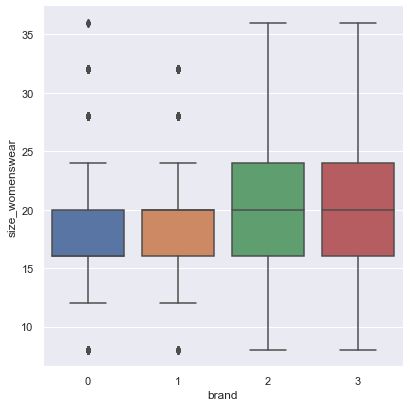

{0: 'Brand 1', 1: 'Brand 2', 2: 'Brand 3', 3: 'other'}


3    29848
0    27912
2    20648
1     1593
Name: brand, dtype: int64

In [26]:
# brand
sns.catplot('brand', 'size_womenswear', data=train, kind='box')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.5)
plt.show()

# correspondence
print(dict(zip([0, 1, 2, 3], list_brand)))

# value counts
train['brand'].value_counts()

- **Brand 3 and 'others'** have customers with a **broader range of dress size**.

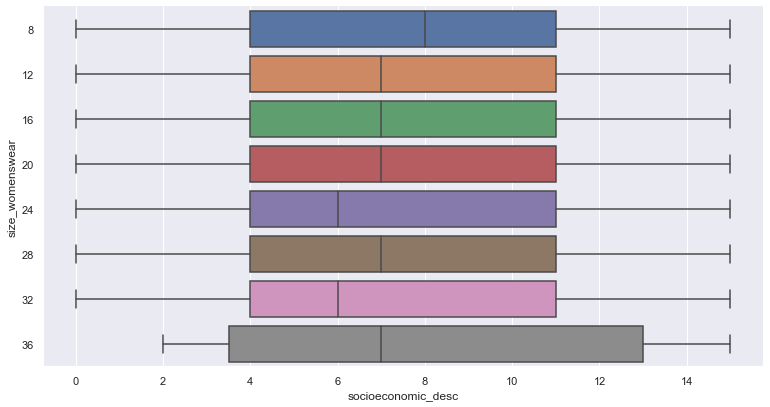

Correlation between socioeconomic_desc and size: -0.003094814862537439


In [27]:
# Last. Excludind customer_id, size_womenswear and binary variables
for i in train.columns[2:][10:].drop('order_method'):  
    sns.catplot(i, 'size_womenswear', data=train, kind='box', orient="h")
    plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0.3, hspace=0.5)
    plt.show()
    print("""Correlation between {} and size: {}""".format(i, train['size_womenswear'].corr(train[i])))

- socioeconomic_desc is not correlated with size.

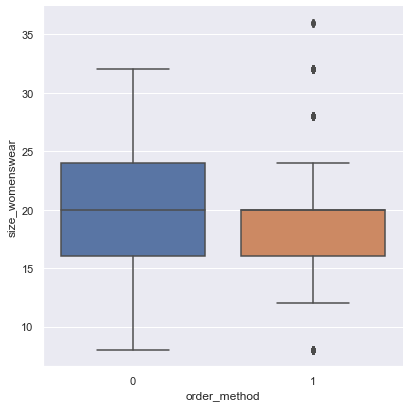

{0: 'offline', 1: 'online'}


1    59249
0    20752
Name: order_method, dtype: int64

In [28]:
# order_method
sns.catplot('order_method', 'size_womenswear', data=train, kind='box')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.3, hspace=0.5)
plt.show()

# correspondence
print(dict(zip([0, 1], list_order_method)))

# value counts
train['order_method'].value_counts()

## 1.3) Other relationships

### Clustermap

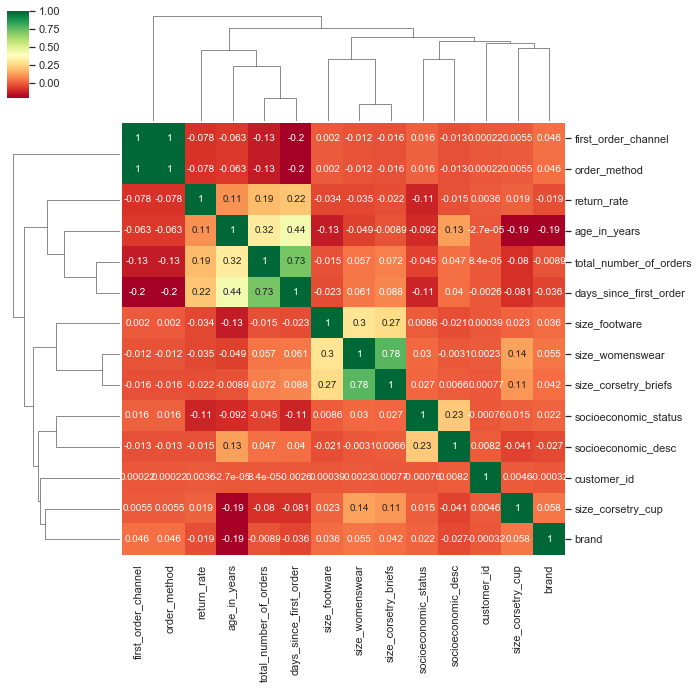

In [29]:
# map
sns.clustermap(train.corr(method='pearson'), cmap='RdYlGn', annot=True)
plt.show()

### Age and return rate

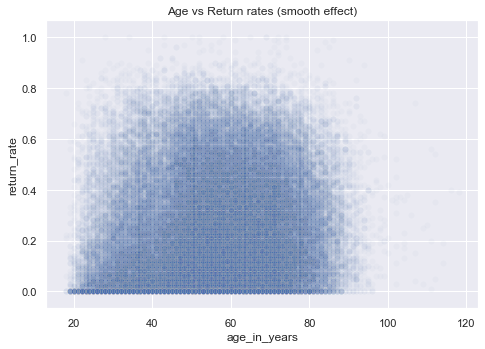

In [30]:
# age vs return rate
sns.scatterplot('age_in_years', 'return_rate', data=train, alpha=0.03)

plt.title('Age vs Return rates (smooth effect)')

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()

- There is a **correlation of 11% between age and return rate.** We see that **up until age 40** return rates are fairly **lower** when comparing with older people. The difference in return rate means (0.26 - 0.198) is **statistically significant.**

In [31]:
%%time
# is the difference statistically significant?

rr_young = train[train['age_in_years'] < 40].return_rate
rr_old = train[train['age_in_years'] >= 40].return_rate

print("Return rate mean for customers younger than 40: {}".format(round(rr_young.mean(), 3)))
print("Return rate mean for customers older than 40: {}".format(round(rr_old.mean(), 3)))
print("Mean difference: {}".format(round(rr_old.mean() - rr_young.mean(), 3)))

# mean difference
def diff_of_means(data_1, data_2):
    diff = np.mean(data_1) - np.mean(data_2)
    return diff

############################

# mean difference 
empirical_diff_means = diff_of_means(rr_old, rr_young)  

# Drawing 10000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(rr_old, rr_young, diff_of_means, size=10000)

# Computing p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

print('p-value =', p)

Return rate mean for customers younger than 40: 0.198
Return rate mean for customers older than 40: 0.263
Mean difference: 0.066
p-value = 0.0
Wall time: 29.7 s


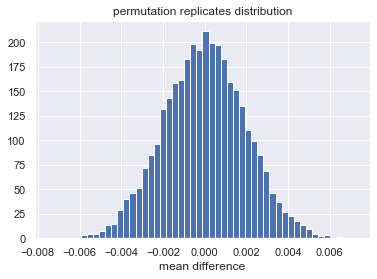

In [32]:
# permutation replicates distribution
plt.hist(perm_replicates, bins=50, density=True)
plt.title('permutation replicates distribution')
plt.xlabel('mean difference')
plt.show()

### Brand

In [33]:
train['brand'].value_counts()

3    29848
0    27912
2    20648
1     1593
Name: brand, dtype: int64

In [34]:
%%script false
# brand and others
for i in train.columns[1:].drop('brand'):
    sns.catplot('brand', i, data=train, alpha=0.05)
    plt.xticks([0, 1, 2, 3], list_brand)
    plt.show()    

Couldn't find program: 'false'


Brand 1 has a mean return rate of 0.26.
Brand 2 has a mean return rate of 0.18.
Brand 3 has a mean return rate of 0.25.
other has a mean return rate of 0.25.


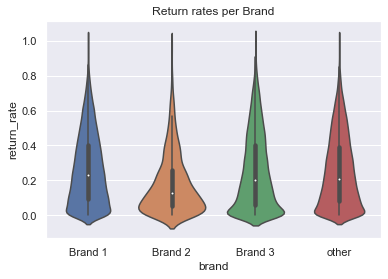

In [35]:
# mean return rates per brand
[print("""{} has a mean return rate of {}.""".format(list_brand[i], 
                                         round(train[train['brand'] == i].return_rate.mean(), 2))) for i in [0, 1, 2, 3]]

# brand and return rate
sns.violinplot('brand', 'return_rate', data=train, alpha=0.05)
plt.title('Return rates per Brand')
plt.xticks([0, 1, 2, 3], list_brand)
plt.show()

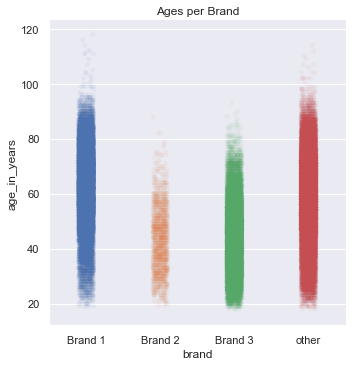

In [36]:
# brand and age
sns.catplot('brand', 'age_in_years', data=train, alpha=0.05)
plt.title('Ages per Brand')
plt.xticks([0, 1, 2, 3], list_brand)
plt.show()

### socioeconomic_status and Return rates

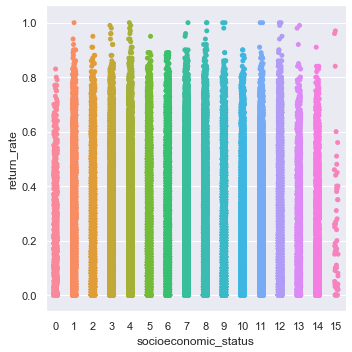

In [37]:
sns.catplot('socioeconomic_status', 'return_rate', data=train)
plt.show()

In [38]:
%%script false
# pairplot - relationships between all the variables
sns.pairplot(train)

plt.subplots_adjust(left=0, bottom=-3, right=3, top=1, wspace=0, hspace=0)
plt.show()

Couldn't find program: 'false'


## 2) Prediction models

In [39]:
train.columns

Index(['customer_id', 'size_womenswear', 'total_number_of_orders',
       'return_rate', 'first_order_channel', 'socioeconomic_status',
       'size_corsetry_cup', 'size_corsetry_briefs', 'size_footware',
       'days_since_first_order', 'brand', 'age_in_years', 'socioeconomic_desc',
       'order_method'],
      dtype='object')

In [40]:
# model prediction

X = train.drop(['size_womenswear', 'customer_id'], axis=1)
y = train['size_womenswear']

# Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# for reproducibility
SEED = 10

### 2.1) Random Forest Classifier

In [41]:
%%time
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
clf_rf = RandomForestClassifier(random_state=SEED, class_weight='balanced', n_estimators=100)

# train the model
clf_rf.fit(X_train, y_train)

Wall time: 13.9 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [42]:
model = clf_rf
model_name = 'RandomForestClassifier'

# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo'))

Score: 0.687457033935379

Confusion matrix:
 [[  14  141   12   12    1    4    0    0]
 [   3 1601  556   85   34   12    4    0]
 [   0  421 3610  801   91   32   10    0]
 [   1   74  568 3217  572   70   19    0]
 [   0   35   80  483 1797  230   18    0]
 [   0    6   20   57  261  621   74    0]
 [   0    4   10   12   35  151  140    0]
 [   0    0    0    0    0    2    0    0]]

Classification report:
               precision    recall  f1-score   support

           8       0.78      0.08      0.14       184
          12       0.70      0.70      0.70      2295
          16       0.74      0.73      0.74      4965
          20       0.69      0.71      0.70      4521
          24       0.64      0.68      0.66      2643
          28       0.55      0.60      0.57      1039
          32       0.53      0.40      0.45       352
          36       0.00      0.00      0.00         2

    accuracy                           0.69     16001
   macro avg       0.58      0.49      0.50

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8717673628541756


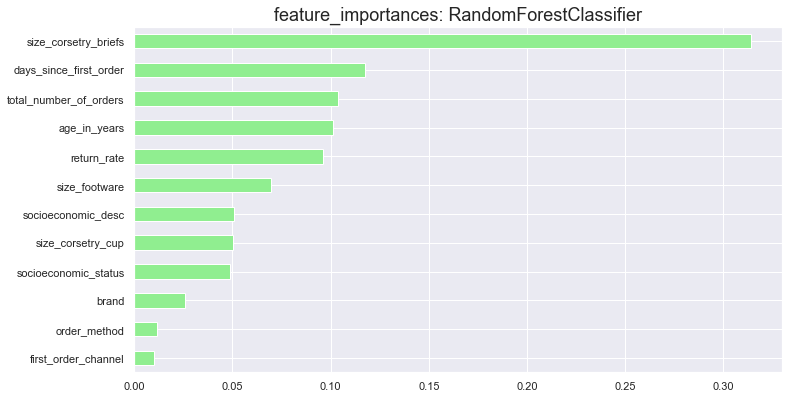

In [43]:
# X columns
X_columns = X.columns

# Create a pd.Series of features feature_importances
feature_importances = pd.Series(data=model.feature_importances_, index=X_columns)

# Sort feature_importances
feature_importances_sorted = feature_importances.sort_values()

# Draw a horizontal barplot of feature_importances_sorted
feature_importances_sorted.tail(100).plot(kind='barh', color='lightgreen')
plt.title('feature_importances: {}'.format(model_name), fontsize=18)
plt.subplots_adjust(left=0, bottom=-0.2, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

### 2.2) XGBoost

In [44]:
%%time
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

#class_weights = compute_class_weight('balanced', y_train.unique(), y_train)

# instantiate the model
clf_xgb = xgb.XGBClassifier(random_state=SEED, n_estimators=100, objective='multi:softmax')

# train the model
clf_xgb.fit(X_train, y_train)

Wall time: 49.7 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [45]:
# num_class in the scikit-learn API for XGBoost classification is done automatically when fit is called
clf_xgb.n_classes_ 

8

In [46]:
model = clf_xgb
model_name = 'XGBClassifier'

# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo'))

Score: 0.6960189988125742

Confusion matrix:
 [[  18  138   11   13    1    2    1    0]
 [  10 1612  538   86   34    7    8    0]
 [   5  416 3609  802   85   31   17    0]
 [   2   76  545 3228  583   55   32    0]
 [   1   35   75  444 1837  221   30    0]
 [   0    7   17   56  228  620  111    0]
 [   0    4    8   17   23   87  213    0]
 [   0    0    0    1    0    0    1    0]]

Classification report:
               precision    recall  f1-score   support

           8       0.50      0.10      0.16       184
          12       0.70      0.70      0.70      2295
          16       0.75      0.73      0.74      4965
          20       0.69      0.71      0.70      4521
          24       0.66      0.70      0.68      2643
          28       0.61      0.60      0.60      1039
          32       0.52      0.61      0.56       352
          36       0.00      0.00      0.00         2

    accuracy                           0.70     16001
   macro avg       0.55      0.52      0.5

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8974415767704532


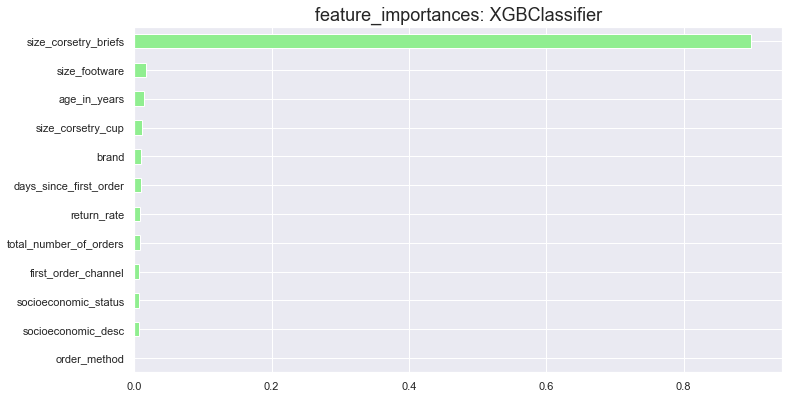

In [47]:
# X columns
X_columns = X.columns

# Create a pd.Series of features feature_importances
feature_importances = pd.Series(data=model.feature_importances_, index=X_columns)

# Sort feature_importances
feature_importances_sorted = feature_importances.sort_values()

# Draw a horizontal barplot of feature_importances_sorted
feature_importances_sorted.tail(100).plot(kind='barh', color='lightgreen')
plt.title('feature_importances: {}'.format(model_name), fontsize=18)
plt.subplots_adjust(left=0, bottom=-0.2, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

### 2.3) LGBMClassifier

In [48]:
%%time
import lightgbm as lgb

# instantiate the model
clf_lgb = lgb.LGBMClassifier(random_state=SEED, n_estimators=100, class_weight='balanced')

# train the model
clf_lgb.fit(X_train, y_train)

Wall time: 6.83 s


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=10, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [49]:
model = clf_lgb
model_name = 'LGBMClassifier'

# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo'))

Score: 0.678457596400225

Confusion matrix:
 [[  67   89   11   12    1    2    2    0]
 [ 298 1327  537   83   33    9    8    0]
 [  61  365 3603  795   85   31   25    0]
 [  11   71  540 3193  575   71   60    0]
 [   3   33   74  433 1825  231   44    0]
 [   1    8   16   50  221  606  137    0]
 [   2    2    9   10   21   73  235    0]
 [   0    0    0    0    1    0    1    0]]

Classification report:
               precision    recall  f1-score   support

           8       0.15      0.36      0.21       184
          12       0.70      0.58      0.63      2295
          16       0.75      0.73      0.74      4965
          20       0.70      0.71      0.70      4521
          24       0.66      0.69      0.68      2643
          28       0.59      0.58      0.59      1039
          32       0.46      0.67      0.54       352
          36       0.00      0.00      0.00         2

    accuracy                           0.68     16001
   macro avg       0.50      0.54      0.51

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8718613302674739


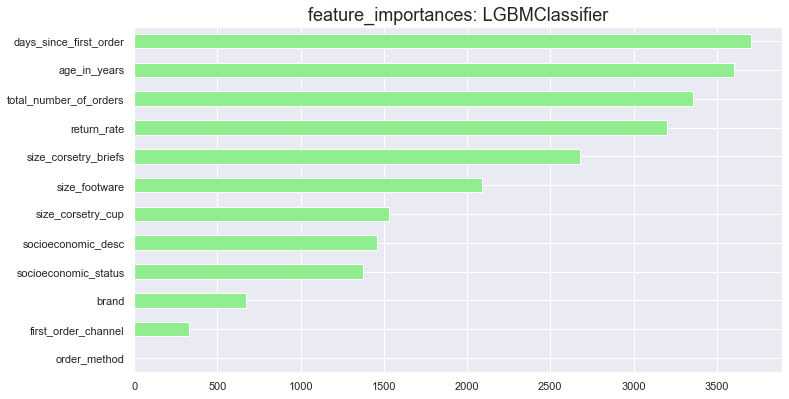

In [50]:
# X columns
X_columns = X.columns

# Create a pd.Series of features feature_importances
feature_importances = pd.Series(data=model.feature_importances_, index=X_columns)

# Sort feature_importances
feature_importances_sorted = feature_importances.sort_values()

# Draw a horizontal barplot of feature_importances_sorted
feature_importances_sorted.tail(100).plot(kind='barh', color='lightgreen')
plt.title('feature_importances: {}'.format(model_name), fontsize=18)
plt.subplots_adjust(left=0, bottom=-0.2, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

### 2.4) DecisionTree Classifier

In [51]:
%%time
from sklearn.tree import DecisionTreeClassifier

# instantiate the model
clf_dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')

# train the model
clf_dt.fit(X_train, y_train)

Wall time: 802 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=10, splitter='best')

In [52]:
model = clf_dt
model_name = 'DecisionTreeClassifier'

# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))


Score: 0.513967877007687

Confusion matrix:
 [[  21   94   42   17    6    4    0    0]
 [ 101 1180  747  175   64   17   11    0]
 [  52  719 2836 1042  234   64   18    0]
 [   9  182  992 2378  776  152   32    0]
 [   8   74  223  708 1279  304   47    0]
 [   1   22   49  122  322  414  108    1]
 [   0    6   24   33   48  125  116    0]
 [   0    1    0    1    0    0    0    0]]

Classification report:
               precision    recall  f1-score   support

           8       0.11      0.11      0.11       184
          12       0.52      0.51      0.52      2295
          16       0.58      0.57      0.57      4965
          20       0.53      0.53      0.53      4521
          24       0.47      0.48      0.48      2643
          28       0.38      0.40      0.39      1039
          32       0.35      0.33      0.34       352
          36       0.00      0.00      0.00         2

    accuracy                           0.51     16001
   macro avg       0.37      0.37      0.37

### 2.5) Logistic Regression

In [53]:
# FOR LINEAR MODELS

# train_linear
train_linear = pd.read_csv('uc_data_train.csv').drop('Unnamed: 0', axis=1)

# Scaling in scikit-learn
from sklearn.preprocessing import scale

# scale
train_linear[train_linear[numeric].drop(['customer_id', 'size_womenswear'], axis=1).columns] = scale(
    train_linear[train_linear[numeric].drop(['customer_id', 'size_womenswear'], axis=1).columns])

# one hot encoding
train_linear = pd.get_dummies(train_linear)

#####################################

X_linear = train_linear.drop(['size_womenswear', 'customer_id'], axis=1)
y_linear = train_linear['size_womenswear']

# Split
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, 
                                                                                y_linear,
                                                                                test_size=0.2, stratify=y_linear, 
                                                                                random_state=1)

train_linear.head()

,customer_id,size_womenswear,total_number_of_orders,return_rate,first_order_channel,size_corsetry_cup,size_corsetry_briefs,size_footware,days_since_first_order,age_in_years,...,socioeconomic_desc_Rental Hubs,socioeconomic_desc_Rural Reality,socioeconomic_desc_Senior Security,socioeconomic_desc_Suburban Stability,socioeconomic_desc_Transient Renters,socioeconomic_desc_Unclassified,socioeconomic_desc_Urban Cohesion,socioeconomic_desc_Vintage Value,order_method_offline,order_method_online
0,1,16,-0.504843,-0.647575,-1.689704,1.622087,-0.625649,0.397087,0.663224,-0.603038,...,0,0,0,0,0,0,0,0,1,0
1,2,20,0.903716,1.744484,0.591820,-0.817447,0.125349,-0.287657,0.884917,1.091277,...,0,0,0,0,0,0,0,0,0,1
2,3,8,1.013270,-1.038115,0.591820,-0.817447,-1.376647,-1.657146,0.355598,0.569949,...,0,0,0,1,0,0,0,0,0,1
3,4,12,0.762860,0.816951,-1.689704,0.402320,-1.376647,0.397087,0.409396,0.830613,...,0,0,0,1,0,0,0,0,1,0
4,5,16,-0.363987,0.035871,-1.689704,-0.207564,-0.625649,-0.287657,-0.250989,0.374451,...,0,0,0,0,0,0,0,0,1,0


In [54]:
%%time
from sklearn.linear_model import LogisticRegression

# instantiate the model
clf_logreg = LogisticRegression(class_weight='balanced', solver='lbfgs', multi_class='auto', random_state=SEED)

# train the model
clf_logreg.fit(X_train_linear, y_train_linear)

Wall time: 5.8 s


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=10, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
model = clf_logreg
model_name = 'LogisticRegression'

# Model performance

# predict
y_pred = model.predict(X_test_linear)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test_linear, y_test_linear))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test_linear, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test_linear, y_pred))


Score: 0.5945253421661146

Confusion matrix:
 [[ 132   27    9   12    0    1    3    0]
 [ 969  724  468   77   31    9   13    4]
 [ 362  366 3309  740  109   30   39   10]
 [  62   45  599 2990  636   67   87   35]
 [  20   19   77  429 1704  267  108   19]
 [   2    5   18   45  200  431  293   45]
 [   3    3    6   10   15   47  223   45]
 [   0    0    0    0    0    0    2    0]]

Classification report:
               precision    recall  f1-score   support

           8       0.09      0.72      0.15       184
          12       0.61      0.32      0.42      2295
          16       0.74      0.67      0.70      4965
          20       0.69      0.66      0.68      4521
          24       0.63      0.64      0.64      2643
          28       0.51      0.41      0.46      1039
          32       0.29      0.63      0.40       352
          36       0.00      0.00      0.00         2

    accuracy                           0.59     16001
   macro avg       0.44      0.51      0.4

## 2.6) Comparing all models

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


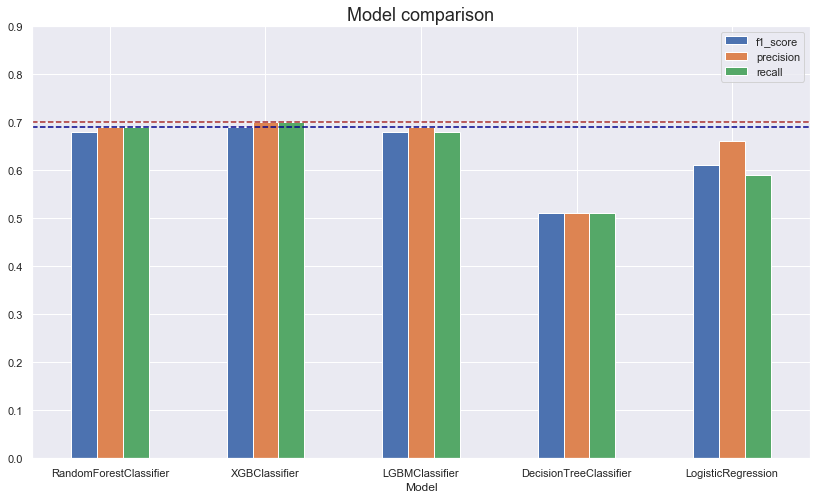

In [56]:
from sklearn.metrics import f1_score, precision_score, recall_score

# results for 
clf_rf_res, clf_xgb_res, clf_lgb_res, clf_dt_res, clf_logreg_res = [], [], [], [], []

# store results
for i in ['clf_rf', 'clf_xgb', 'clf_lgb', 'clf_dt']:
    globals()[i+'_res'].append(round(f1_score(y_test, globals()[i].predict(X_test), average='weighted'), 2))
    globals()[i+'_res'].append(round(precision_score(y_test, globals()[i].predict(X_test), average='weighted'), 2))
    globals()[i+'_res'].append(round(recall_score(y_test, globals()[i].predict(X_test), average='weighted'), 2))
    
clf_logreg_res = [round(f1_score(y_test_linear, clf_logreg.predict(X_test_linear), average='weighted'), 2),
              round(precision_score(y_test_linear, clf_logreg.predict(X_test_linear), average='weighted'), 2),
              round(recall_score(y_test_linear, clf_logreg.predict(X_test_linear), average='weighted'), 2)]

# build dataframe with results
r_columns = ['f1_score', 'precision', 'recall']
r_index = ['RandomForestClassifier', 'XGBClassifier', 'LGBMClassifier', 'DecisionTreeClassifier', 'LogisticRegression']

results = pd.DataFrame(np.row_stack([clf_rf_res, clf_xgb_res, clf_lgb_res, clf_dt_res, clf_logreg_res]),
                       index=r_index, columns=r_columns)

# plot
results.plot(kind='bar')

# formatting
plt.title("Model comparison", fontsize=18)
plt.xlabel("Model")
#plt.ylim(0, .8)
plt.yticks(np.arange(0, 1, 0.1))
plt.axhline(y=np.max(results['f1_score']), c='darkblue', linestyle='--')
plt.axhline(y=np.max(results['precision']), c='brown', linestyle='--')
plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=360)
plt.subplots_adjust(left=0, bottom=-0.5, right=1.8, top=1, wspace=0, hspace=0)
plt.show()

## 3) Dimension reduction & Feature selection

### 3.1) PCA

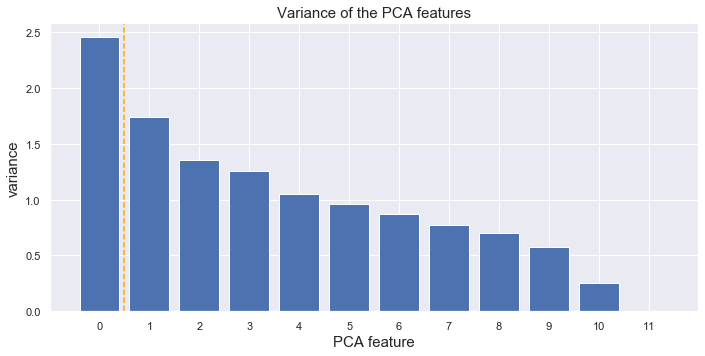

Wall time: 560 ms


In [57]:
%%time

# scaling the features
X_pca = scale(X.copy())

# Initialize a new PCA model with the default number of components.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_pca)

# features
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_)

# formatting
plt.title("Variance of the PCA features", fontsize=15)
plt.xlabel('PCA feature', fontsize=15)
plt.ylabel('variance', fontsize=15)
plt.xticks(np.arange(0, len(X.columns), 1))
plt.axvline(x=0.5, c='orange', linestyle='--')

plt.subplots_adjust(left=0, bottom=0, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

('reducer', PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False))

Explained_variance_ratio_ cumulative sum: [0.20494158 0.35015973 0.46290203 0.56811843 0.65587073 0.73596514
 0.80837589 0.87265229 0.93082822 0.97879477 1.         1.        ]


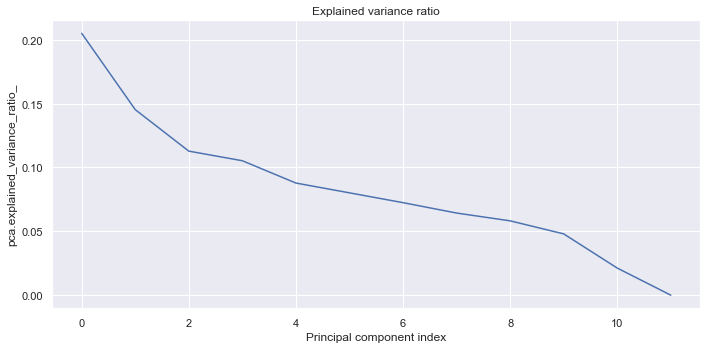

Wall time: 33.5 s


In [58]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('reducer', PCA(n_components=len(X.columns))), 
                 ('classifier', clf_rf)])

pipe.fit(X_train, y_train)

print(pipe.steps[1])  # [0] é o scaler, [1] o PCA e [2] o modelo

print("\nExplained_variance_ratio_ cumulative sum:", pipe.steps[1][1].explained_variance_ratio_.cumsum())

# An optimal number of components
var = pipe.steps[1][1].explained_variance_ratio_

plt.plot(var)

plt.title("Explained variance ratio")
plt.xlabel('Principal component index')
plt.ylabel('pca.explained_variance_ratio_')

plt.subplots_adjust(left=0, bottom=0, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

### 3.2) Recursive Feature Elimination

In [59]:
%%time
# feature selection with RFE and LGBMClassifier
from sklearn.feature_selection import RFE

steps = 1
n_features = 1

# Recursive Feature Elimination
rfe = RFE(estimator=clf_rf, 
          n_features_to_select=n_features, 
          step=steps,
          verbose=1)

# fit
rfe.fit(X_train, y_train)

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Wall time: 2min 38s


RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight='balanced', criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=None,
                                     oob_score=False, random_state=10,
                                     verbose=0, warm_start=False),
    n_features_to_select=1, step=1, verbose=1)

In [60]:
print(dict(zip(X_train.columns, rfe.ranking_)))

{'total_number_of_orders': 3, 'return_rate': 5, 'first_order_channel': 12, 'socioeconomic_status': 6, 'size_corsetry_cup': 9, 'size_corsetry_briefs': 2, 'size_footware': 7, 'days_since_first_order': 1, 'brand': 10, 'age_in_years': 4, 'socioeconomic_desc': 8, 'order_method': 11}


In [61]:
X.columns[rfe.ranking_ <= 5].tolist()

['total_number_of_orders',
 'return_rate',
 'size_corsetry_briefs',
 'days_since_first_order',
 'age_in_years']

In [62]:
%%time
# check f1_score average scores with different features/ranking
for i in range(1, len(X.columns)):
    
    ranking_x = i
    
    imp_variables = X.columns[rfe.ranking_ <= i].tolist()  # variables to consider according to ranking i
    
    # New model
    X_train_new = X_train[imp_variables]
    X_test_new = X_test[imp_variables]
    
    # classifier
    clf_rf_2 = RandomForestClassifier(random_state=SEED, n_estimators=100, class_weight='balanced')
    clf_rf_2.fit(X_train_new, y_train)
    
    # Compute and print f1 score
    f1score = round(f1_score(y_test, clf_rf_2.predict(X_test_new), average='weighted'), 2)

    print("With a RFE ranking until {}, the f1-score is {}".format(ranking_x, f1score))

With a RFE ranking until 1, the f1-score is 0.18
With a RFE ranking until 2, the f1-score is 0.57
With a RFE ranking until 3, the f1-score is 0.58
With a RFE ranking until 4, the f1-score is 0.66
With a RFE ranking until 5, the f1-score is 0.68
With a RFE ranking until 6, the f1-score is 0.68
With a RFE ranking until 7, the f1-score is 0.68
With a RFE ranking until 8, the f1-score is 0.68
With a RFE ranking until 9, the f1-score is 0.69
With a RFE ranking until 10, the f1-score is 0.69
With a RFE ranking until 11, the f1-score is 0.69
Wall time: 2min 26s


### 3.3) TSNE

In [63]:
%%time
# Fitting t-SNE
from sklearn.manifold import TSNE

m = TSNE(learning_rate=200)

tsne_features = m.fit_transform(train)  #this will project the high dimensional data set onto a np array with 2 dimensions

# Assigning t-SNE features to our dataset
train_2 = train.copy()
train_2['x'] = tsne_features[:,0]
train_2['y'] = tsne_features[:,1]

Wall time: 19min 50s


In [64]:
train_2.columns

Index(['customer_id', 'size_womenswear', 'total_number_of_orders',
       'return_rate', 'first_order_channel', 'socioeconomic_status',
       'size_corsetry_cup', 'size_corsetry_briefs', 'size_footware',
       'days_since_first_order', 'brand', 'age_in_years', 'socioeconomic_desc',
       'order_method', 'x', 'y'],
      dtype='object')

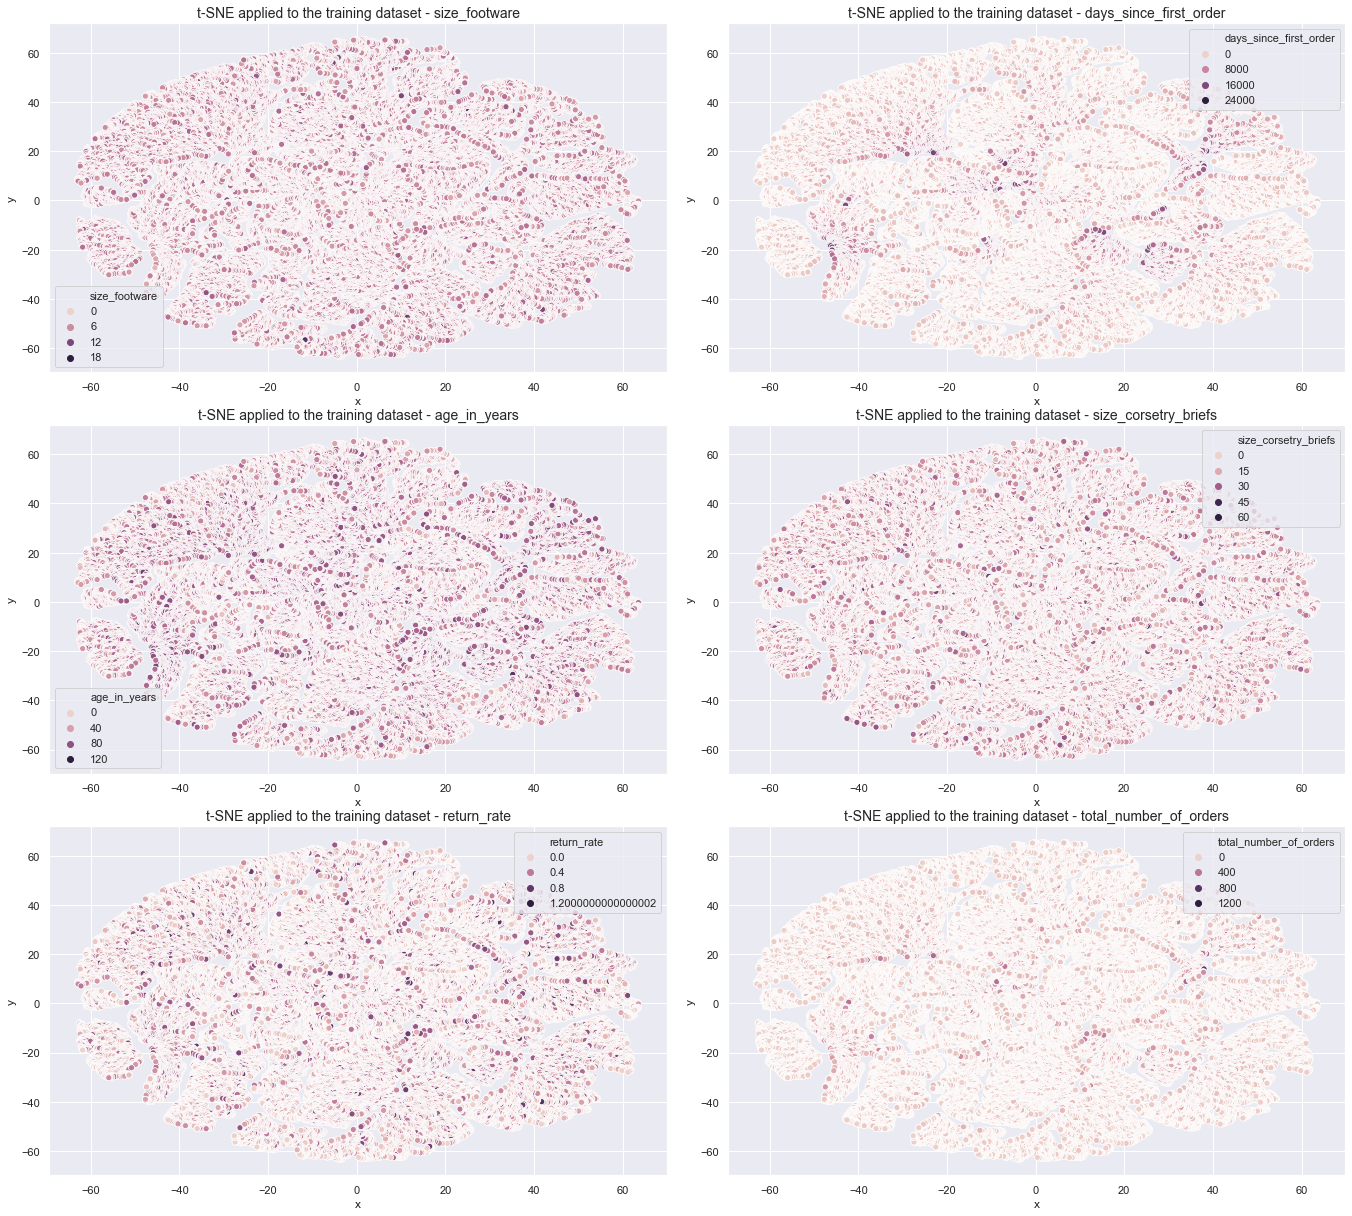

In [65]:
# Plotting t-SNE

watch_tsne = ['size_footware', 'days_since_first_order', 'age_in_years', 'size_corsetry_briefs', 'return_rate',
             'total_number_of_orders']

for i, var in enumerate(watch_tsne):
    plt.subplot(3, 2, i+1)
    sns.scatterplot(x="x", y="y", data=train_2, hue=var)
    plt.title("t-SNE applied to the training dataset - {}".format(var), fontsize=14)

plt.subplots_adjust(left=0, bottom=-3, right=3, top=1, wspace=0.1, hspace=0.15)
plt.show()


Now, testing only with size_corsetry_briefs:

#### with RandomForestClassifier - 1 variable

In [66]:
train.columns

Index(['customer_id', 'size_womenswear', 'total_number_of_orders',
       'return_rate', 'first_order_channel', 'socioeconomic_status',
       'size_corsetry_cup', 'size_corsetry_briefs', 'size_footware',
       'days_since_first_order', 'brand', 'age_in_years', 'socioeconomic_desc',
       'order_method'],
      dtype='object')

In [67]:
%%time
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
clf_rf_3 = RandomForestClassifier(random_state=SEED, class_weight='balanced', n_estimators=100)

#######################################

imp_variables = ['size_corsetry_briefs']

X_train_new = X_train[imp_variables]
X_test_new = X_test[imp_variables]

# train the model
clf_rf_3.fit(X_train_new, y_train)

#####################################

model = clf_rf_3
model_name = 'RandomForestClassifier modified'

# Model performance

# predict
y_pred = model.predict(X_test_new)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test_new, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, model.predict_proba(X_test_new), average='weighted', multi_class='ovo'))

Score: 0.6933316667708268

Confusion matrix:
 [[  35  121   11   12    1    2    1    1]
 [  20 1602  537   81   34    7   10    4]
 [  10  411 3606  782   85   27   25   19]
 [   6   73  543 3173  586   53   38   49]
 [   1   35   74  427 1836  221   35   14]
 [   0    7   17   49  223  611  126    6]
 [   0    4    8   10   22   71  230    7]
 [   0    0    0    0    0    0    1    1]]

Classification report:
               precision    recall  f1-score   support

           8       0.49      0.19      0.27       184
          12       0.71      0.70      0.70      2295
          16       0.75      0.73      0.74      4965
          20       0.70      0.70      0.70      4521
          24       0.66      0.69      0.68      2643
          28       0.62      0.59      0.60      1039
          32       0.49      0.65      0.56       352
          36       0.01      0.50      0.02         2

    accuracy                           0.69     16001
   macro avg       0.55      0.59      0.5

#### with XGBoost

In [68]:
%%time
import xgboost as xgb

#class_weights = compute_class_weight('balanced', y_train.unique(), y_train)

# instantiate the model
clf_xgb_2 = xgb.XGBClassifier(random_state=SEED, n_estimators=100, objective='multi:softmax')

#######################################

imp_variables = ['size_corsetry_briefs']

X_train_new = X_train[imp_variables]
X_test_new = X_test[imp_variables]

# train the model
clf_xgb_2.fit(X_train_new, y_train)

#####################################

model = clf_xgb_2
model_name = 'XGBClassifier modified'

# Model performance

# predict
y_pred = model.predict(X_test_new)

from sklearn.metrics import confusion_matrix, classification_report

# score
print("Score:", model.score(X_test_new, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, model.predict_proba(X_test_new), average='weighted', multi_class='ovo'))


Score: 0.6963314792825448

Confusion matrix:
 [[  35  121   11   13    1    2    1    0]
 [  20 1602  537   86   34    6   10    0]
 [  10  411 3606  803   85   25   25    0]
 [   6   73  543 3222  586   53   38    0]
 [   1   35   74  443 1836  219   35    0]
 [   0    7   17   55  223  611  126    0]
 [   0    4    8   18   22   70  230    0]
 [   0    0    0    1    0    0    1    0]]

Classification report:
               precision    recall  f1-score   support

           8       0.49      0.19      0.27       184
          12       0.71      0.70      0.70      2295
          16       0.75      0.73      0.74      4965
          20       0.69      0.71      0.70      4521
          24       0.66      0.69      0.68      2643
          28       0.62      0.59      0.60      1039
          32       0.49      0.65      0.56       352
          36       0.00      0.00      0.00         2

    accuracy                           0.70     16001
   macro avg       0.55      0.53      0.5

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8882772176176906
Wall time: 14.1 s


### 4) Hyperparameter Tuning

### With all features

In [69]:
%%time
from sklearn.model_selection import GridSearchCV

# we will use all the parameters
rf = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')

# Set the hyperparameter grid of rf
params_rf = {'criterion': ['gini', 'entropy'], 
             'min_samples_leaf':[1, 2, 3],
             'max_features':['auto', 'log2'],
             'min_samples_split':[2, 3, 4],
             'max_depth':[None, 2, 4]
            }

# GridSearchCV
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=3, n_jobs=-1, verbose=1, scoring='f1_weighted')

# Fit to the training set
grid_rf.fit(X_train, y_train)      

# Extract best hyperparameters
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 13.6min finished


Best hyperparameters:
 {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2}
Wall time: 13min 49s


In [70]:
model = grid_rf
model_name = 'Tuned RandomForestClassifier'

# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo'))

Score: 0.6913726048972498

Confusion matrix:
 [[  24  132   11   12    1    3    1    0]
 [  12 1610  537   84   34   10    8    0]
 [   6  415 3606  797   83   37   21    0]
 [   2   77  545 3178  583   83   53    0]
 [   0   36   74  430 1823  247   33    0]
 [   0    6   19   50  218  627  119    0]
 [   0    4    8   11   20   96  213    0]
 [   0    0    0    0    0    1    1    0]]

Classification report:
               precision    recall  f1-score   support

           8       0.55      0.13      0.21       184
          12       0.71      0.70      0.70      2295
          16       0.75      0.73      0.74      4965
          20       0.70      0.70      0.70      4521
          24       0.66      0.69      0.67      2643
          28       0.57      0.60      0.59      1039
          32       0.47      0.61      0.53       352
          36       0.00      0.00      0.00         2

    accuracy                           0.69     16001
   macro avg       0.55      0.52      0.5

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8814209346391033


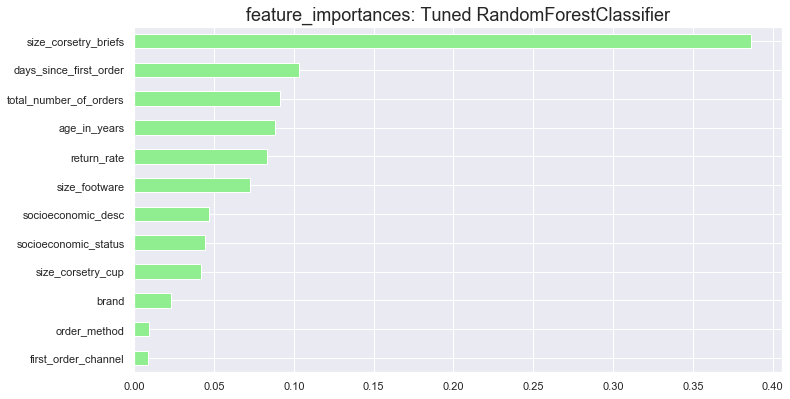

In [71]:
# tuned model
tuned_rf = RandomForestClassifier(n_estimators=300, random_state=SEED, class_weight='balanced', min_samples_leaf=3)
tuned_rf.fit(X_train, y_train)

model = tuned_rf
model_name = 'Tuned RandomForestClassifier'

# X columns
X_columns = X.columns

# Create a pd.Series of features feature_importances
feature_importances = pd.Series(data=model.feature_importances_, index=X_columns)

# Sort feature_importances
feature_importances_sorted = feature_importances.sort_values()

# Draw a horizontal barplot of feature_importances_sorted
feature_importances_sorted.tail(100).plot(kind='barh', color='lightgreen')
plt.title('feature_importances: {}'.format(model_name), fontsize=18)
plt.subplots_adjust(left=0, bottom=-0.2, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

### With only 1 feature

In [72]:
%%time
from sklearn.model_selection import GridSearchCV

# we will use all the parameters
rf = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')

# Set the hyperparameter grid of rf
params_rf = {'criterion': ['gini', 'entropy'], 
             'min_samples_leaf':[1, 2, 3],
             'max_features':['auto', 'log2'],
             'min_samples_split':[2, 3, 4],
             'max_depth':[None, 2, 4]
            }

# GridSearchCV
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=3, n_jobs=-1, verbose=1, scoring='f1_weighted')

# Fit to the training set - only 1 feature
grid_rf.fit(X_train[['size_corsetry_briefs']], y_train)      

# Extract best hyperparameters
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  3.1min finished


Best hyperparameters:
 {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2}
Wall time: 3min 7s


In [73]:
model = grid_rf
model_name = 'Tuned RandomForestClassifier'

# Model performance

# predict
y_pred = model.predict(X_test[['size_corsetry_briefs']])

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test[['size_corsetry_briefs']], y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
print("ROC AUC score: ", 
      roc_auc_score(y_test, model.predict_proba(X_test[['size_corsetry_briefs']]), average='weighted', multi_class='ovo'))

Score: 0.6946078217801559

Confusion matrix:
 [[  35  121   11   12    1    2    1    1]
 [  20 1602  537   81   34    7   10    4]
 [  10  411 3606  782   85   27   25   19]
 [   6   73  543 3173  586   53   38   49]
 [   1   35   74  427 1836  221   35   14]
 [   0    7   17   49  223  611  126    6]
 [   0    4    8   10   22   71  230    7]
 [   0    0    0    0    0    0    1    1]]

Classification report:
               precision    recall  f1-score   support

           8       0.49      0.19      0.27       184
          12       0.71      0.70      0.70      2295
          16       0.75      0.73      0.74      4965
          20       0.70      0.70      0.70      4521
          24       0.66      0.69      0.68      2643
          28       0.62      0.59      0.60      1039
          32       0.49      0.65      0.56       352
          36       0.01      0.50      0.02         2

    accuracy                           0.69     16001
   macro avg       0.55      0.59      0.5

In [74]:
%%time
from sklearn.model_selection import GridSearchCV

# we will use all the parameters
rf = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')

# Set the hyperparameter grid of rf
params_rf = {'n_estimators': [100, 300, 400]}

# GridSearchCV
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=3, n_jobs=-1, verbose=1, scoring='f1_weighted')

# Fit to the training set - only 1 feature
grid_rf.fit(X_train[['size_corsetry_briefs']], y_train)      

# Extract best hyperparameters
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   19.0s finished


Best hyperparameters:
 {'n_estimators': 100}
Wall time: 21 s


In [75]:
model = grid_rf
model_name = 'Tuned RandomForestClassifier'

# Model performance

# predict
y_pred = model.predict(X_test[['size_corsetry_briefs']])

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test[['size_corsetry_briefs']], y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
print("ROC AUC score: ",
      roc_auc_score(y_test, model.predict_proba(X_test[['size_corsetry_briefs']]), average='weighted', multi_class='ovo'))

Score: 0.6946078217801559

Confusion matrix:
 [[  35  121   11   12    1    2    1    1]
 [  20 1602  537   81   34    7   10    4]
 [  10  411 3606  782   85   27   25   19]
 [   6   73  543 3173  586   53   38   49]
 [   1   35   74  427 1836  221   35   14]
 [   0    7   17   49  223  611  126    6]
 [   0    4    8   10   22   71  230    7]
 [   0    0    0    0    0    0    1    1]]

Classification report:
               precision    recall  f1-score   support

           8       0.49      0.19      0.27       184
          12       0.71      0.70      0.70      2295
          16       0.75      0.73      0.74      4965
          20       0.70      0.70      0.70      4521
          24       0.66      0.69      0.68      2643
          28       0.62      0.59      0.60      1039
          32       0.49      0.65      0.56       352
          36       0.01      0.50      0.02         2

    accuracy                           0.69     16001
   macro avg       0.55      0.59      0.5

### With all again

In [76]:
%%time
from sklearn.model_selection import GridSearchCV

# we will use all the parameters
rf = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')

# Set the hyperparameter grid of rf
params_rf = {'n_estimators': [100, 300, 500], 
             'min_samples_leaf':[1, 3, 4]}

# GridSearchCV
grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, cv=3, n_jobs=-1, verbose=1, scoring='f1_weighted')

# Fit to the training set
grid_rf.fit(X_train, y_train)      

# Extract best hyperparameters
best_hyperparams = grid_rf.best_params_
print('Best hyperparameters:\n', best_hyperparams)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  5.7min finished


Best hyperparameters:
 {'min_samples_leaf': 3, 'n_estimators': 300}
Wall time: 6min 10s


In [77]:
model = grid_rf
model_name = 'Tuned RandomForestClassifier'

# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, model.predict_proba(X_test), average='weighted', multi_class='ovo'))

Score: 0.6915396195384954

Confusion matrix:
 [[  24  132   11   12    1    2    2    0]
 [   9 1614  536   84   35   10    7    0]
 [   5  417 3605  793   83   38   24    0]
 [   1   78  543 3180  575   91   53    0]
 [   0   36   74  429 1823  244   37    0]
 [   0    7   17   50  218  625  122    0]
 [   0    4    8   11   19   98  212    0]
 [   0    0    0    0    0    1    1    0]]

Classification report:
               precision    recall  f1-score   support

           8       0.62      0.13      0.22       184
          12       0.71      0.70      0.70      2295
          16       0.75      0.73      0.74      4965
          20       0.70      0.70      0.70      4521
          24       0.66      0.69      0.68      2643
          28       0.56      0.60      0.58      1039
          32       0.46      0.60      0.52       352
          36       0.00      0.00      0.00         2

    accuracy                           0.69     16001
   macro avg       0.56      0.52      0.5

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8832308184496501


### 5) FINAL MODEL

In [78]:
final_model = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')

# only 1 feature
final_model.fit(X_train[['size_corsetry_briefs']], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [79]:
# save predictions
test_pred = test.copy()

test_pred['size_womenswear_pred'] = final_model.predict(test[['size_corsetry_briefs']])

test_pred.to_csv('uc_data_test_with_pred.csv')

In [80]:
test_pred.head()

,customer_id,total_number_of_orders,return_rate,first_order_channel,socioeconomic_status,size_corsetry_cup,size_corsetry_briefs,size_footware,days_since_first_order,brand,age_in_years,socioeconomic_desc,order_method,size_womenswear_pred
0,7,17,0.26,2,M,4,20,6,1602,Brand 3,43,Modest Traditions,online,20
1,8,30,0.52,2,L,4,16,8,1809,other,47,Vintage Value,online,16
2,9,9,0.31,2,I,9,16,6,179,Brand 3,60,Family Basics,online,16
3,13,109,0.08,2,M,3,16,7,4455,other,65,Modest Traditions,online,16
4,24,135,0.10,2,F,3,24,6,8752,other,70,Suburban Stability,online,24


In [81]:
pd.read_csv('uc_data_test_with_pred.csv', index_col=0)

,customer_id,total_number_of_orders,return_rate,first_order_channel,socioeconomic_status,size_corsetry_cup,size_corsetry_briefs,size_footware,days_since_first_order,brand,age_in_years,socioeconomic_desc,order_method,size_womenswear_pred
0,7,17,0.26,2,M,4,20,6,1602,Brand 3,43,Modest Traditions,online,20
1,8,30,0.52,2,L,4,16,8,1809,other,47,Vintage Value,online,16
2,9,9,0.31,2,I,9,16,6,179,Brand 3,60,Family Basics,online,16
3,13,109,0.08,2,M,3,16,7,4455,other,65,Modest Traditions,online,16
4,24,135,0.10,2,F,3,24,6,8752,other,70,Suburban Stability,online,24
5,43,65,0.54,2,G,4,16,8,932,Brand 3,48,Domestic Success,online,16
6,45,24,0.16,2,H,4,20,7,3867,Brand 3,43,Aspiring Homemakers,online,20
7,54,23,0.34,2,I,6,12,4,2479,Brand 3,56,Family Basics,online,12
8,55,1,0.00,2,I,3,12,4,76,Brand 1,37,Family Basics,online,12
9,59,41,0.30,2,I,5,16,7,450,Brand 3,35,Family Basics,online,16
